In [36]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import scipy

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [38]:

# Cleaning data functions according to rhe desired data
def clean_merged_data(merged_data):
    relevant_data = pd.DataFrame(index=merged_data.index)
    relevant_data["country"] = merged_data["country"]
    relevant_data["patience"] = merged_data["patience"]
    relevant_data["risktaking"] = merged_data["risktaking"]
    relevant_data["posrecip"] = merged_data["posrecip"]
    relevant_data["negrecip"] = merged_data["negrecip"]
    relevant_data["altruism"] = merged_data["altruism"]
    relevant_data["trust"] = merged_data["trust"]
    relevant_data["wgt_x"] = merged_data["wgt_x"]

    return relevant_data


In [40]:

def clean_merged_data_gender(merged_data, gender):
    relevant_data = pd.DataFrame(index=merged_data.index)
    relevant_data["country"] = merged_data["country"]
    relevant_data["patience"] = merged_data["patience"]
    relevant_data["risktaking"] = merged_data["risktaking"]
    relevant_data["posrecip"] = merged_data["posrecip"]
    relevant_data["negrecip"] = merged_data["negrecip"]
    relevant_data["altruism"] = merged_data["altruism"]
    relevant_data["trust"] = merged_data["trust"]
    relevant_data["gender"] = merged_data["gender"]
    relevant_data = relevant_data[relevant_data["gender"] == gender]

    return relevant_data


In [42]:

def clean_merged_data_region(merged_data,region):
    relevant_data = pd.DataFrame(index=merged_data.index)
    relevant_data["country"] = merged_data["country"]
    relevant_data["patience"] = merged_data["patience"]
    relevant_data["risktaking"] = merged_data["risktaking"]
    relevant_data["posrecip"] = merged_data["posrecip"]
    relevant_data["negrecip"] = merged_data["negrecip"]
    relevant_data["altruism"] = merged_data["altruism"]
    relevant_data["trust"] = merged_data["trust"]

    relevant_data = relevant_data[relevant_data["country"].isin(region)]
    
    return relevant_data


In [43]:
# Generates preference measure by country (full data)
def preference_measure_1000(data, preference):
    df = pd.DataFrame(data.groupby("country")[preference].mean())
    '''
    df = pd.DataFrame()
    for pref in preference:
        df[pref] = data.dropna(subset=[pref, 'wgt_x']).groupby('country').apply(lambda x: np.average(x[pref], weights=x['wgt_x']))
    '''
    return df

In [44]:
# Generates preference measure by country (fraction of the data)
def generate_pref_measure_sample(data):
    preference_measure_sample = pd.DataFrame(data.reset_index().rename(columns={'index': 'country'}).groupby(['country']).mean())
    '''
    preference_measure_sample = pd.DataFrame()
    for pref in preference:
        preference_measure_sample[pref] = data.dropna(subset=[pref, 'wgt_x']).reset_index().rename(columns={'index': 'country'}).groupby(['country']).apply(lambda x: np.average(x[pref], weights=x['wgt_x']))
    '''
    return preference_measure_sample

In [45]:
# Random sampling a fraction of the full data
def random_sampling_pref(data, preference, num_iterations, fraction):
   
    # Initialize an empty DataFrame to store the results
    df = pd.DataFrame()   
    sampled_data = pd.DataFrame()
   
    # Repeat the sampling process for a specified number of iterations
    for i in range(num_iterations):
        # Group by 'country' and sample a fraction of the observations with replacement
        sampled_data = data.groupby("country")[preference].apply(lambda x: x.sample(frac=fraction, replace=True)).reset_index(level=1,drop=True)
        sampled_data.name = f"{preference}_{i+1}"
      
        # Concatenate the sampled data to the result DataFrame
        df = pd.concat([df, sampled_data], axis=1)
    return df

In [46]:
# Computes the correlation between the sampled preference measure
def preferences_measure(relevant, pref, iterations, fraction):

    # compute preference measure for 1000 obs by country
    pref_measure_1000 = preference_measure_1000(relevant, pref)
    pref_measure_1000
    
    # Generate n=len(iterations) samples for a fraction of the population
    pref_samples = random_sampling_pref(relevant,preference=pref, num_iterations=iterations, fraction=fraction)
    pref_samples
    
    pref_measure_samples = generate_pref_measure_sample(pref_samples)
    pref_measure_samples

    # CORRELATIONS
    corrrelation_1000_sample_measure = pref_measure_samples.corr().stack().tolist()
    corrrelation_1000_sample_measure = [corrrelation_1000_sample_measure[i] for i in range(len(corrrelation_1000_sample_measure)) if i % (iterations + 1) != 0]
    corrrelation_1000_sample_measure

    return corrrelation_1000_sample_measure

In [47]:
# Computes the correlation between the sampled preference ranks
def preferences_rank(relevant, pref, iterations, fraction):

    # compute preference measure for 1000 obs by country
    pref_measure_1000 = preference_measure_1000(relevant, pref)
    pref_measure_1000
    
    # compute preference rank for 1000 obs by country
    pref_rank_1000 = pref_measure_1000.rank(ascending=False, method='min')
    pref_rank_1000 = pref_rank_1000.round().astype(pd.Int8Dtype())
    pref_rank_1000

    # Generate n=len(iterations) samples for a fraction of the population
    pref_samples = random_sampling_pref(relevant,preference=pref, num_iterations=iterations, fraction=fraction)
    pref_samples

    pref_measure_samples = generate_pref_measure_sample(pref_samples)
    pref_measure_samples

    pref_rank_samples = pd.DataFrame()  
    for i in pref_measure_samples.columns:
        pref_rank_samples[i] = pref_measure_samples[i].rank(ascending=False, method='min')
        pref_rank_samples[i] = pref_rank_samples[i].round().astype(pd.Int8Dtype())
    pref_rank_samples

    # CORRELATIONS
    corrrelation_1000_sample_rank = pref_rank_samples.corr(method="spearman").stack().tolist()
    corrrelation_1000_sample_rank = [corrrelation_1000_sample_rank[i] for i in range(len(corrrelation_1000_sample_rank)) if i % (iterations + 1) != 0]
    corrrelation_1000_sample_rank

    return corrrelation_1000_sample_rank

Main

In [48]:
# Get data paths
this_path = Path(".")
directory_path = this_path.parent/"data_clean"/"merged_gps_gallup.csv"
directory_path_staircase = this_path.parent/"data_clean"/"staircase_patience.dta"

# Load merged data and select only relevant data ["country", "patience", "risktaking", "posrecip", "negrecip", "altruism", "trust", "wgt_x"]
merged_data = pd.read_csv(directory_path)
relevant_data = clean_merged_data(merged_data)

# Load staicase patience and adjust country names
staircase_patience = pd.read_stata(directory_path_staircase)
staircase_patience["country"] = staircase_patience["country"].replace(' \d','', regex=True)


C:\Users\willi\AppData\Local\Temp\ipykernel_20380\2800559500.py:7: DtypeWarning:

Columns (16,63,66,68,69,71,72,75,79,80,81,82,83,84,86,88,90,91,94,96,97,99,101,102,103,104,105,109,110,111,112,113,114,115,116,117,118,120,121,125,126,129,131,137,138,139,142,144,147,148,149,154,159,163,165,166,168,170,171,173,174,175,178,184,186,187,188,189,190,191,192,193,194,195,198,200,201,202,203,204,205,206,208,209,210,211,213,214,215,216,218,221,222,224,226,231,232,233,237,239,240,241,242,245,246,247,248,252,254,256,260,261,262,263,265,267,268,272,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,354,355,356,357,359,366,368,370,371,372,373,374,375,377,378,379,380,381,382,383,384,386,387,389,395,396,397,398,399,400,401,406,407,413,414,415,416,417,418,419,420,421,422,423

In [49]:
relevant_data

,country,patience,risktaking,posrecip,negrecip,altruism,trust,wgt_x
0,Turkey,0.05,1.02,0.59,-0.37,-0.14,1.68,0.27
1,Turkey,-0.68,0.39,0.66,0.08,-0.14,0.95,0.27
2,Turkey,0.32,1.02,-0.00,0.08,-0.61,0.59,0.44
3,Turkey,0.50,1.27,0.96,0.08,0.56,0.59,1.42
4,Turkey,0.59,1.12,1.33,-0.37,0.33,1.68,0.71
...,...,...,...,...,...,...,...,...
80332,Egypt,-0.68,1.15,0.66,0.37,-0.45,-0.14,1.29
80333,Egypt,-0.55,-1.70,0.36,-0.73,-0.76,0.22,0.76
80334,Egypt,-0.80,-1.87,-0.53,0.52,-0.14,0.59,0.42
80335,Egypt,-1.31,-0.05,-0.00,-0.49,-0.14,0.59,1.14


In [50]:
staircase_patience

,country,stair_patience,id
0,Afghanistan,1.00,7107000000783.00
1,Afghanistan,3.00,7107000000857.00
2,Afghanistan,16.00,7107000000679.00
3,Afghanistan,1.00,7107000000112.00
4,Afghanistan,9.00,7107000000703.00
...,...,...,...
80332,Zimbabwe,1.00,7108100000678.00
80333,Zimbabwe,1.00,7108100000049.00
80334,Zimbabwe,1.00,7108100000502.00
80335,Zimbabwe,1.00,7108100000138.00


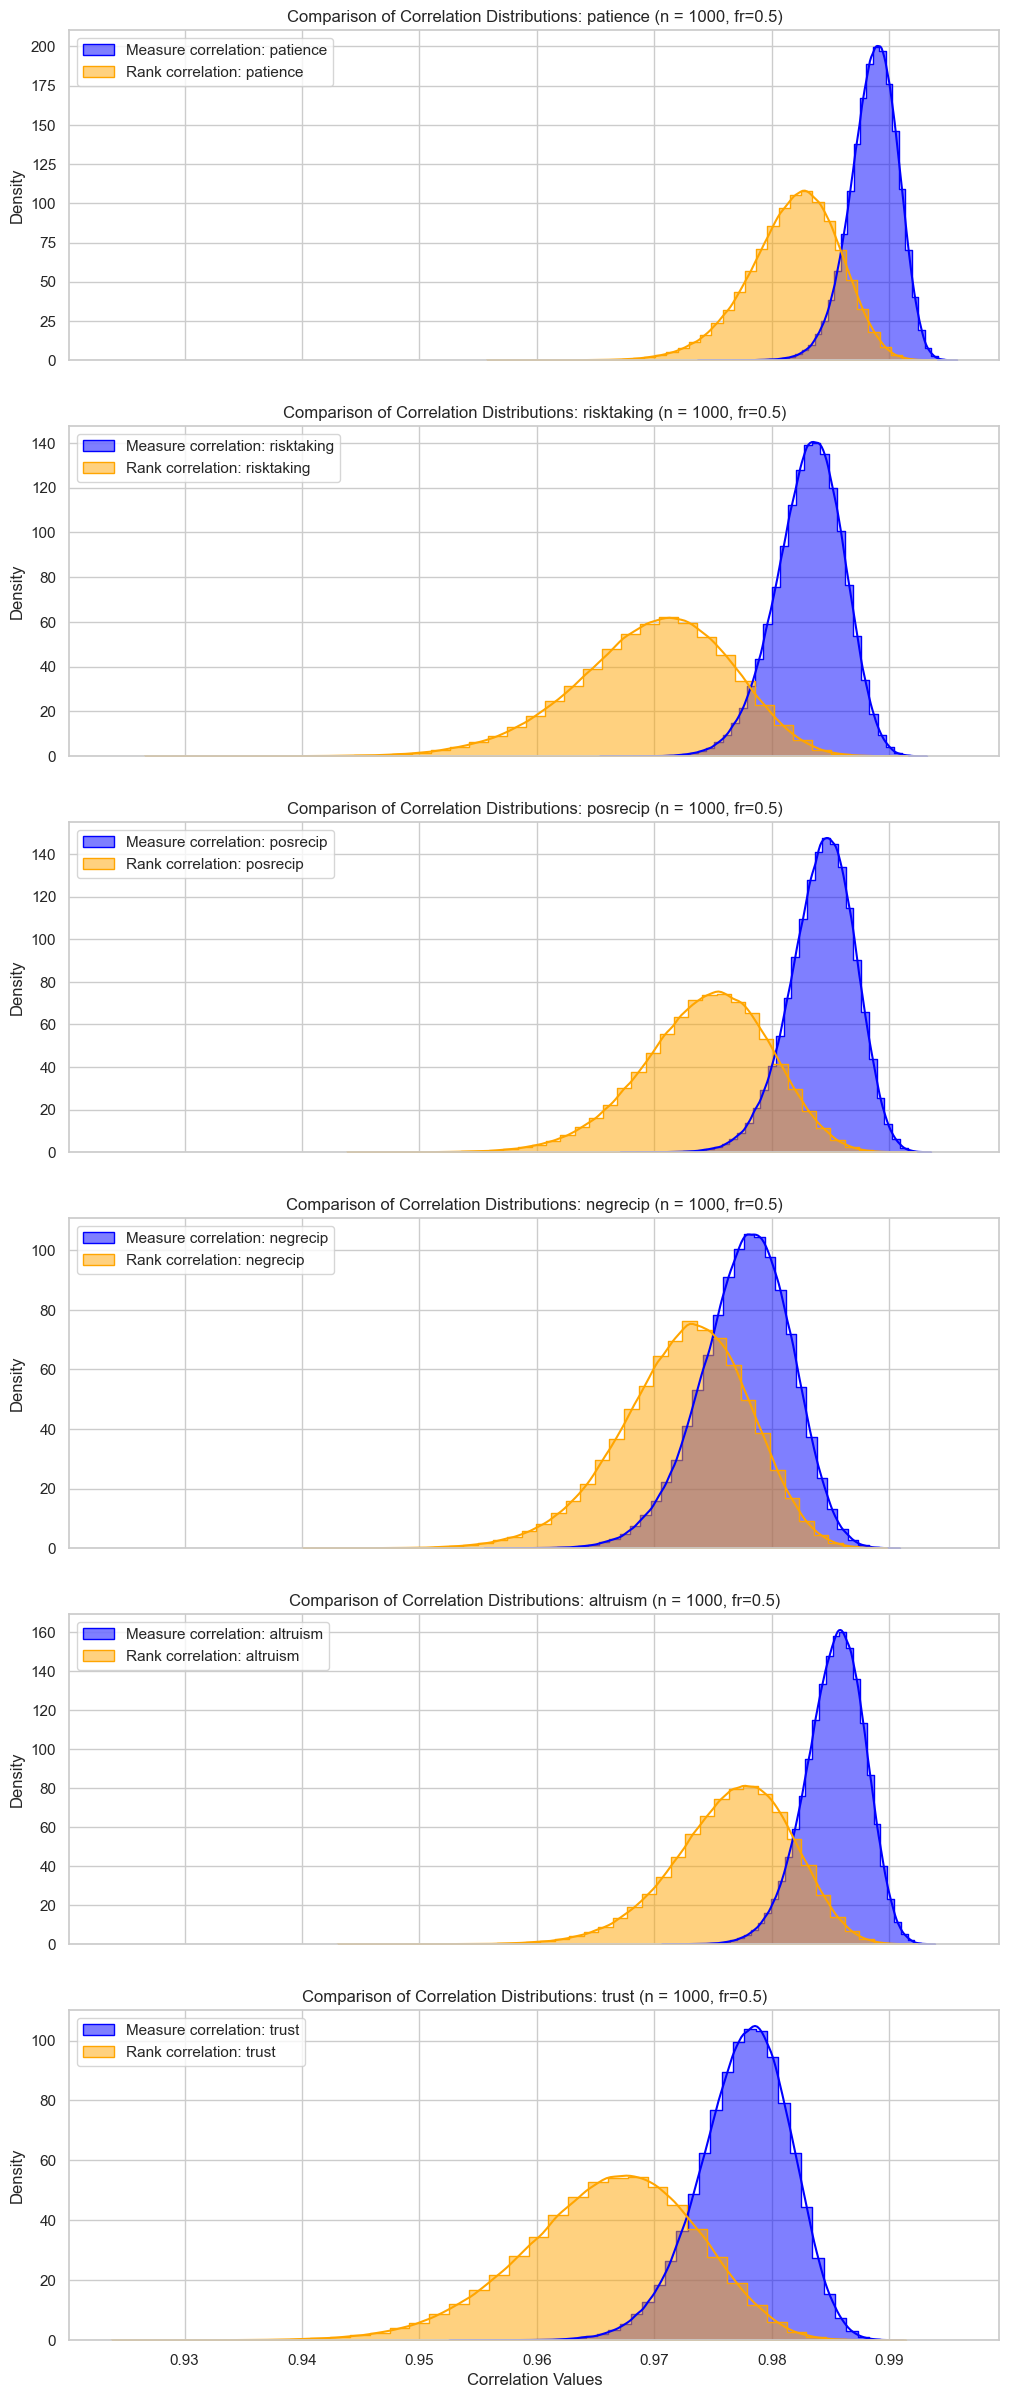

In [51]:
# Measure and rank correlations by preference (iterations = 100, fraction = 0.5)

#preferences = ["patience"]
preferences = ["patience", "risktaking", "posrecip", "negrecip", "altruism", "trust"]

# for loop to generate correlation values for each preference (measure)
for pref in preferences:
    # Construct the variable name dynamically
    variable_name = f"{pref}_measure"

    # Call the preferences_measure function with the dynamic variable name 
    globals()[variable_name] = preferences_measure(relevant_data, pref=pref, iterations=1000, fraction=0.5)

# for loop to generate correlation values for each preference (rank)
for pref in preferences:
    # Construct the variable name dynamically (rank)
    variable_name = f"{pref}_rank"

    # Call the preferences_measure function with the dynamic variable name
    globals()[variable_name] = preferences_rank(relevant_data, pref=pref, iterations=1000, fraction=0.5)

# Plots for measure and rank correlations by preference (iterations = 100, fraction = 0.5)

# Create subplots with 6 rows and 1 column
fig, axes = plt.subplots(len(preferences), 1, figsize=(12, 5 * len(preferences)), sharex=True)

for i, pref in enumerate(preferences):
    # Construct the variable names dynamically
    measure_name = f"{pref}_measure"
    rank_name = f"{pref}_rank"

    # Plotting the histograms
    sns.histplot(globals()[measure_name], bins=40, color='blue', kde=True, label=f'Measure correlation: {pref}', element='step', stat='density', ax=axes[i])
    sns.histplot(globals()[rank_name], bins=40, color='orange', kde=True, label=f'Rank correlation: {pref}', element='step', stat='density', ax=axes[i])

    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Comparison of Correlation Distributions: {pref} (n = 1000, fr=0.5)')
    axes[i].legend()

# Set x-axis label for the last subplot
axes[-1].set_xlabel('Correlation Values')

# Save the combined plot as an image
# plt.savefig(this_path.parent/"plots"/"baseline_measure_VS_rank.png")

# Display the combined plot
plt.show()